# Setup

Here, we already imported most of the packages that you might want to use

In [2]:
import os
import pandas as pd

In [3]:
import pm4py

## Log Util
# Log conversion
from pm4py.objects.conversion.log import converter as log_converter
# Read Log (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.util.log import get_event_labels
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.variants import variants_filter

## Conformance Checking
# Token-based replay (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
# Standard Alignments (e.g., If you can not use the simplified interface because you do not have ipywidgets installed)
from pm4py.algo.conformance.alignments import algorithm as alignments
# Footprint
from pm4py.algo.conformance.footprints import algorithm as footprints_conformance
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery

from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness_evaluator
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator

## Petri Nets
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.petri_net.utils import petri_utils, check_soundness
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.visualization.petri_net import visualizer as pn_visualizer

## Decision Trees
from sklearn import tree
from pm4py.visualization.decisiontree import visualizer as dectree_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
from pm4py.objects.log.util import get_class_representation

c:\users\thinkpad x1\appdata\local\programs\python\python38\lib\site-packages\pm4py\algo\conformance\alignments\algorithm.py:19: UserWarning: please use pm4py.algo.conformance.alignments.petri_net.algorithm instead
  warnings.warn("please use pm4py.algo.conformance.alignments.petri_net.algorithm instead")


In [17]:
def prepare_dict(dict1, dict2):
    # dict1 = alignment
    # dict2 = token_replay
    res = dict()
    for key in dict1:
        if key == 'percFitTraces':
            res[key] = [dict1[key], dict2['perc_fit_traces']]
        elif key == 'averageFitness':
            res[key] = [dict1[key], dict2['average_trace_fitness']]
        else:
            res[key] = [dict1[key], dict2[key]]
    return res

# Hints
**Have look at the simplified interface of PM4Py $\rightarrow$ Click on the 'See Simplified Interface' buttons on the documentation page**

Good way to convert a DataFrame so that it works nicely in PM4Py
```python
df = pm4py.format_dataframe(df, case_id=case_id_column activity_key=activity_column, timestamp_key=timestamp_column)
```

If you do not have ipywidgets installed, you'll probably encounter the ```IProgress not found``` error.
In that case, it should help to deactivate the progress bar by passing a dictionary with the following key:
```python
{'show_progress_bar': False}
```
However, currently you can not use the simplified interface then. Instead you have to use the base functions.
For example, for importing a log without progress bar, you can use
```
log = xes_importer.apply('log.xes',parameters={'show_progress_bar':False})
```
If you have ipywidgets installed
```python
log = pm4py.read_xes(file_path)
```
can be used.

In [18]:
log = pm4py.read_xes("logs/log_vaccination.xes")

parsing log, completed traces ::   0%|          | 0/4960 [00:00<?, ?it/s]

# Process Overview

# Process Discovery

 <font size="5">Question 2a</font>

In [19]:
from pm4py.algo.filtering.log.end_activities import end_activities_filter

true_end_activities = ['Checkout No Vacc', 'Decline Vaccination', 'Destroy Vacc', 'Notify about vacc. possibility',
                       'Send Vaccination Certificate']
in_log_end_activities = set(end_activities_filter.get_end_activities(log).keys())
filtered_log = end_activities_filter.apply(log, true_end_activities)

removed_activities = in_log_end_activities - set(true_end_activities)

print(f'Size of original log: {len(log)}')
print(f'Size of filtered log: {len(filtered_log)}')
print(f'Removed end activities: {removed_activities}')

Size of original log: 4960
Size of filtered log: 3444
Removed end activities: {'Checkout', 'Priority Appointment granted', 'Send Invoice', 'Decline vaccination', 'Vaccinate'}


 <font size="5">Question 2b</font>

In [20]:
log_2b = pm4py.read_xes("logs/log_vaccination_finished_cases.xes")
from pm4py.objects.petri.importer import importer as petri_net_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
from pm4py.algo.evaluation.precision import algorithm as precision_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator

parsing log, completed traces ::   0%|          | 0/3978 [00:00<?, ?it/s]

In [21]:
def fitness_precision_df_calculator(net, initial_marking, final_marking):
    try:
        aligned_traces_IM = alignments.apply_log(log_2b, net, initial_marking, final_marking)
        fitness_alignment_IM = replay_fitness.evaluate(aligned_traces_IM, variant=replay_fitness.Variants.ALIGNMENT_BASED)
        precision_alignment_IM = precision_evaluator.apply(log_2b, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)
    except:
        fitness_alignment_IM = {'percFitTraces': 0, 'averageFitness': 0, 'percentage_of_fitting_traces': 0, 'average_trace_fitness': 0}
        precision_alignment_IM = 0
    replayed_traces_IM = token_replay.apply(log_2b, net, initial_marking, final_marking)
    fitness_token_replay_IM = replay_fitness.evaluate(replayed_traces_IM, variant=replay_fitness.Variants.TOKEN_BASED)
    precision_token_replay_IM = precision_evaluator.apply(log_2b, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

    df_fitness = pd.DataFrame(prepare_dict(fitness_alignment_IM, fitness_token_replay_IM), index = ['alignment', 'token_replay'])
    df_precision = pd.DataFrame({'precision': [precision_alignment_IM, precision_token_replay_IM]}, index = ['alignment', 'token_replay'])
    return pd.concat([df_fitness, df_precision], axis=1)

def simplicity_and_generalization_calculator(net, initial_marking, final_marking):
    simplicity = simplicity_evaluator.apply(net)
    generalization = generalization_evaluator.apply(log_2b, net, initial_marking, final_marking)
    return simplicity, generalization

In [22]:
net_IM, initial_marking_IM, final_marking_IM = petri_net_importer.apply('./pnml/Petri-net-IM.pnml')
df_IM = fitness_precision_df_calculator(net_IM, initial_marking_IM, final_marking_IM)
print('Inductive Miner')
df_IM

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

Inductive Miner


,percFitTraces,averageFitness,percentage_of_fitting_traces,average_trace_fitness,log_fitness,precision
alignment,44.94721,0.924319,44.94721,0.924319,0.945467,0.920100
token_replay,44.94721,0.936411,44.94721,0.936411,0.965519,0.919382


In [23]:
net_Alpha, initial_marking_Alpha, final_marking_Alpha = petri_net_importer.apply('./pnml/Petri-net-Alpha.pnml')
df_alpha = fitness_precision_df_calculator(net_Alpha, initial_marking_Alpha, final_marking_Alpha)
print('Alpha Miner')
df_alpha

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

Alpha Miner


,percFitTraces,averageFitness,percentage_of_fitting_traces,average_trace_fitness,precision
alignment,0.0,0.000000,0.0,0.000000,0.000000
token_replay,0.0,0.770813,0.0,0.770813,0.399455


In [24]:
net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic = petri_net_importer.apply('./pnml/Petri-net-Heuristic.pnml')
df_Heuristic = fitness_precision_df_calculator(net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic)
print('Heuristic Miner')
df_Heuristic

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

Heuristic Miner


,percFitTraces,averageFitness,percentage_of_fitting_traces,average_trace_fitness,log_fitness,precision
alignment,1.231775,0.802888,1.231775,0.802888,0.828002,0.799438
token_replay,1.231775,0.953413,1.231775,0.953413,0.966809,0.799438


In [25]:
net_ILP, initial_marking_ILP, final_marking_ILP = petri_net_importer.apply('./pnml/Petri-net-ILP.pnml')
df_ILP = fitness_precision_df_calculator(net_ILP, initial_marking_ILP, final_marking_ILP)
print('ILP Miner')
df_ILP

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

ILP Miner


,percFitTraces,averageFitness,percentage_of_fitting_traces,average_trace_fitness,log_fitness,precision
alignment,31.171443,0.837280,31.171443,0.837280,0.883531,0.937179
token_replay,31.171443,0.927118,31.171443,0.927118,0.962532,0.910164


In [26]:
net_state_region_miner, initial_marking_state_region_miner, final_marking_state_region_miner = petri_net_importer.apply(
    './pnml/Petri-net-state-region-miner.pnml')
df_state_region_miner = fitness_precision_df_calculator(net_state_region_miner, initial_marking_state_region_miner, final_marking_state_region_miner)
print('State Region Miner')
df_state_region_miner


replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2925 [00:00<?, ?it/s]

State Region Miner


,percFitTraces,averageFitness,percentage_of_fitting_traces,average_trace_fitness,precision
alignment,0.0,0.000000,0.0,0.000000,0.000000
token_replay,0.0,0.928056,0.0,0.928056,0.540627


In [27]:
simplicity_IM, generalization_IM = simplicity_and_generalization_calculator(net_IM, initial_marking_IM, final_marking_IM)
simplicity_alpha, generalization_alpha = simplicity_and_generalization_calculator(net_Alpha, initial_marking_Alpha, final_marking_Alpha)
simplicity_heuristic, generalization_heuristic = simplicity_and_generalization_calculator(net_Heuristic, initial_marking_Heuristic, final_marking_Heuristic)
simplicity_ilp, generalization_ilp = simplicity_and_generalization_calculator(net_ILP, initial_marking_ILP, final_marking_ILP)
simplicity_state_region_miner, generalization_state_region_miner = simplicity_and_generalization_calculator(net_state_region_miner, initial_marking_state_region_miner, final_marking_state_region_miner)

df_simplicity_generalition = pd.DataFrame({
    'simplicity': [simplicity_IM, simplicity_alpha, simplicity_heuristic, simplicity_ilp, simplicity_state_region_miner],
    'generalization': [generalization_IM, generalization_alpha, generalization_heuristic, generalization_ilp, generalization_state_region_miner]
}, index=['IM', 'Alpha', 'Heuristic', 'ILP', 'State Region'])

df_simplicity_generalition

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

,simplicity,generalization
IM,0.795918,0.937063
Alpha,0.398601,0.972661
Heuristic,0.664596,0.932175
ILP,0.271028,0.984557
State Region,0.473684,0.883210


# Conformance Checking

In [8]:
from pm4py.algo.conformance.footprints.util import evaluation as fp_evaluation
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness

# Prepare the log
log_finished_cases=pm4py.read_xes("logs/log_vaccination_finished_cases.xes")

parsing log, completed traces ::   0%|          | 0/3978 [00:00<?, ?it/s]

# Question 3a

In [9]:
import pm4py.visualization.footprints.visualizer as fp_visualizer

# Import the model of inductive and heuristic miner
pn_inductive, im_inductive, fm_inductive = pnml_importer.apply("pnml/Petri-net-IM.pnml")
pn_heuristic, im_heuristic, fm_heuristic = pnml_importer.apply("pnml/Petri-net-Heuristic.pnml")

The inductive miner model:


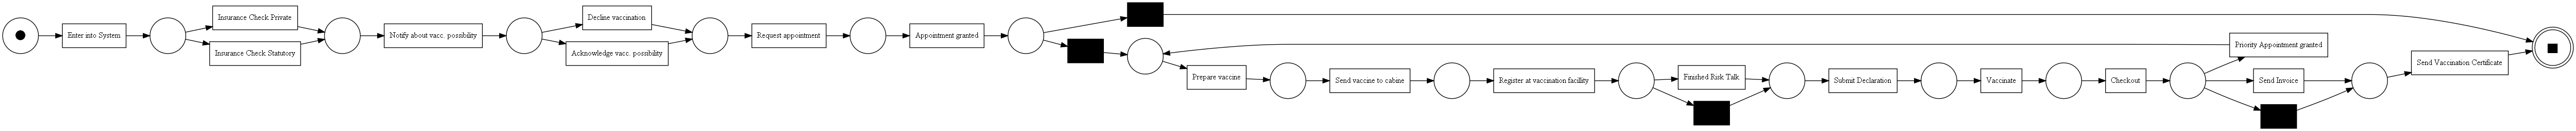

The heuristic miner model:


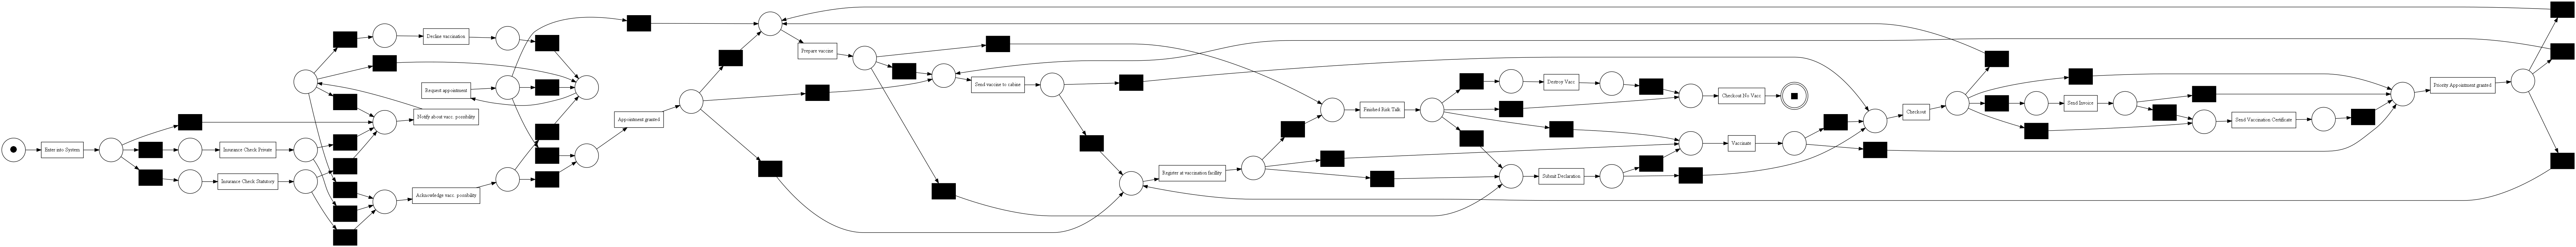

The footprints matrix of the inductive miner model:


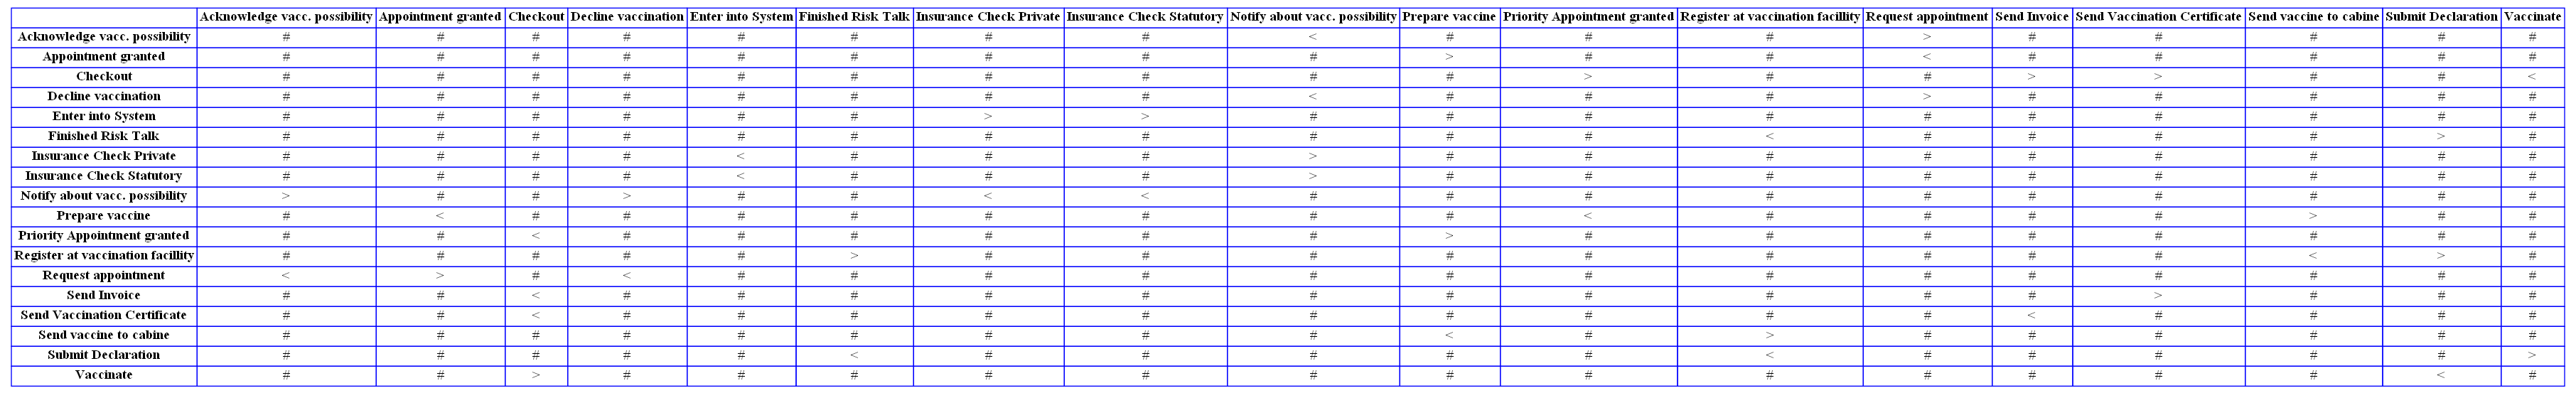

The footprints matrix of the heuristic miner model:


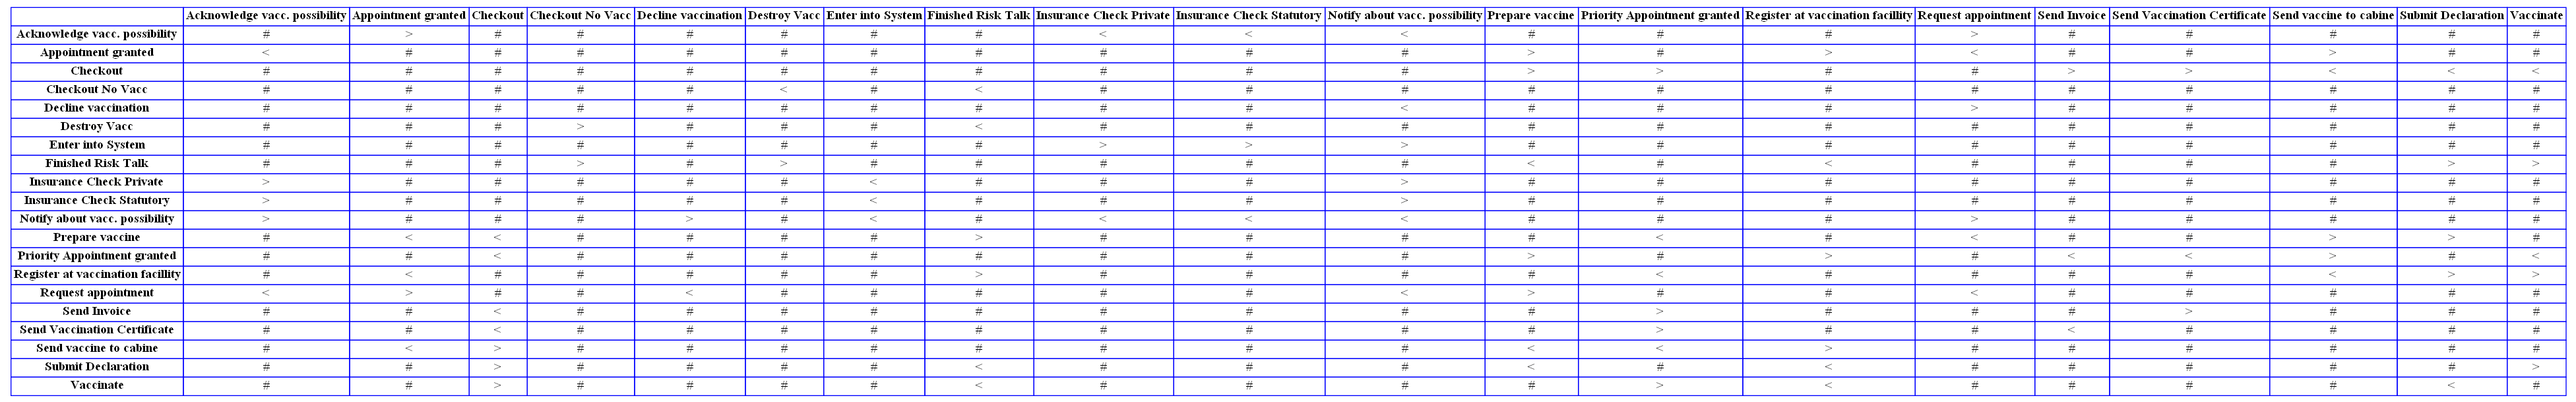

{'sequence': {('Register at vaccination facillity', 'Submit Declaration'), ('Insurance Check Statutory', 'Notify about vacc. possibility'), ('Enter into System', 'Insurance Check Statutory'), ('Appointment granted', 'Prepare vaccine'), ('Submit Declaration', 'Vaccinate'), ('Send Invoice', 'Send Vaccination Certificate'), ('Register at vaccination facillity', 'Finished Risk Talk'), ('Checkout', 'Priority Appointment granted'), ('Notify about vacc. possibility', 'Acknowledge vacc. possibility'), ('Enter into System', 'Insurance Check Private'), ('Checkout', 'Send Invoice'), ('Prepare vaccine', 'Send vaccine to cabine'), ('Vaccinate', 'Checkout'), ('Insurance Check Private', 'Notify about vacc. possibility'), ('Acknowledge vacc. possibility', 'Request appointment'), ('Decline vaccination', 'Request appointment'), ('Priority Appointment granted', 'Prepare vaccine'), ('Checkout', 'Send Vaccination Certificate'), ('Notify about vacc. possibility', 'Decline vaccination'), ('Finished Risk Talk

In [10]:
fp_inductive = footprints_discovery.apply(pn_inductive, im_inductive, fm_inductive)
fp_heuristic = footprints_discovery.apply(pn_heuristic, im_heuristic, fm_heuristic)

print("The inductive miner model:")
gviz = pn_visualizer.apply(pn_inductive, im_inductive, fm_inductive)
pn_visualizer.view(gviz)

print("The heuristic miner model:")
gviz = pn_visualizer.apply(pn_heuristic, im_heuristic, fm_heuristic)
pn_visualizer.view(gviz)

print("The footprints matrix of the inductive miner model:")
gviz = fp_visualizer.apply(fp_inductive)
fp_visualizer.view(gviz)

print("The footprints matrix of the heuristic miner model:")
gviz = fp_visualizer.apply(fp_heuristic)
fp_visualizer.view(gviz)



print(fp_inductive)
print(fp_heuristic)
print(f"The inductive miner model has {len(fp_inductive['sequence'])} sequence contructs and {len(fp_inductive['parallel'])} parallel constructs")
print(f"The heuristic miner model has {len(fp_heuristic['sequence'])} sequence contructs and {len(fp_heuristic['parallel'])} parallel constructs")

# Question 3b

In [11]:
# Import the full hand model
pn_full_hand, im_full_hand, fm_full_hand = pnml_importer.apply("models/full_hand.pnml")

In [12]:
# Helper functions to calculate conformance
def calculate_conformance(algo, log, pn, im, fm):
    return algo(log, pn, im, fm)

# Calculate footprints conformance
# UNRELIABLE FUNCTION, PM4PY BUGGED
def fp_conformance(log, pn, im, fm):
    fp_log = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
    fp_pn = footprints_discovery.apply(pn, im, fm)
    fp_res = footprints_conformance.apply(fp_log, fp_pn, variant=footprints_conformance.Variants.LOG_EXTENSIVE)
    fp_fitness = fp_evaluation.fp_fitness(fp_log, fp_pn, fp_res)
    print(f"The fitness of the model according to footprint matrix is {fp_fitness}")
    return fp_fitness

# Calculate token-based replay conformance
def tbr_conformance(log, pn, im, fm):
    # Replaying traces
    replayed_traces = token_replay.apply(log, pn, im, fm)

    # Calculating the total number of misisng, consumed, remaining, producde tokens
    m, c, r, p = 0, 0, 0, 0
    for res in replayed_traces:
        m += res['missing_tokens']
        c += res['consumed_tokens']
        r += res['remaining_tokens']
        p += res['produced_tokens']

    # Final result as log fitness
    tbr_fitness = 0.5*(1-m/c)+0.5*(1-r/p)
    print(f"The fitness of the model according to token-based replay is {tbr_fitness}")
    
    return tbr_fitness

# Calculate alignments-based conformance
def alignments_conformance(log, pn, im, fm):
    aligned_traces = alignments.apply_log(log, pn, im, fm)
    alignments_fitness = replay_fitness.evaluate(aligned_traces, variant=replay_fitness.Variants.ALIGNMENT_BASED)['log_fitness']
    print(f"The fitness of the model according to alignments is {alignments_fitness}")
    return alignments_fitness

In [13]:
# Footprints conformance
calculate_conformance(fp_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

The fitness of the model according to footprint matrix is 0.9047722487656111


0.9047722487656111

In [14]:
# Token-based replay
calculate_conformance(tbr_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

replaying log with TBR, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to token-based replay is 0.9695556239672888


0.9695556239672888

In [15]:
# Alignments
calculate_conformance(alignments_conformance, log_finished_cases, pn_full_hand, im_full_hand, fm_full_hand)

aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to alignments is 0.9598597978930206


0.9598597978930206

# Question 3c

In [16]:
# Import the logs and the models
log_one_trace = xes_importer.apply("logs/one_trace_log.xes")
pn_flower, im_flower, fm_flower = pnml_importer.apply("models/flower.pnml")

parsing log, completed traces ::   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
# Log of finished cases and the flower model
calculate_conformance(fp_conformance, log_finished_cases, pn_flower, im_flower, fm_flower)
calculate_conformance(alignments_conformance, log_finished_cases, pn_flower, im_flower, fm_flower)

The fitness of the model according to footprint matrix is 1.0


aligning log, completed variants ::   0%|          | 0/409 [00:00<?, ?it/s]

The fitness of the model according to alignments is 0.9999890530526768


0.9999890530526768

In [22]:
# One-trace log and the full hand model
calculate_conformance(tbr_conformance, log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
calculate_conformance(alignments_conformance, log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)

The fitness of the model according to token-based replay is 0.9333333333333333
The fitness of the model according to alignments is 0.6206853745836236


0.6206853745836236

In [27]:
# Viewing the alignment of the one-trace log
one_trace_align = alignments.apply(log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
one_trace_align

[{'alignment': [('Enter into System', 'Enter into System'),
   ('Insurance Check Statutory', 'Insurance Check Statutory'),
   ('Notify about vacc. possibility', 'Notify about vacc. possibility'),
   ('Acknowledge vacc. possibility', 'Acknowledge vacc. possibility'),
   ('Acknowledge vacc. possibility', '>>'),
   ('Request appointment', '>>'),
   ('Request appointment', 'Request appointment'),
   ('Appointment granted', 'Appointment granted'),
   ('Appointment granted', '>>'),
   ('Prepare vaccine', 'Prepare vaccine'),
   ('Prepare vaccine', '>>'),
   ('Send vaccine to cabine', '>>'),
   ('Send vaccine to cabine', 'Send vaccine to cabine'),
   ('Register at vaccination facillity', 'Register at vaccination facillity'),
   ('Register at vaccination facillity', '>>'),
   ('Finished Risk Talk', '>>'),
   ('Finished Risk Talk', 'Finished Risk Talk'),
   ('>>', None),
   ('Submit Declaration', 'Submit Declaration'),
   ('Submit Declaration', '>>'),
   ('Vaccinate', 'Vaccinate'),
   ('Vaccinat

In [28]:
# Viewing the token based replay of the one-trace log
tokens = token_replay.apply(log_one_trace, pn_full_hand, im_full_hand, fm_full_hand)
tokens

[{'trace_is_fit': False,
  'trace_fitness': 0.9333333333333333,
  'activated_transitions': [(n26, 'Enter into System'),
   (n28, 'Insurance Check Statutory'),
   (n29, 'Notify about vacc. possibility'),
   (n30, 'Acknowledge vacc. possibility'),
   (n30, 'Acknowledge vacc. possibility'),
   (n32, 'Request appointment'),
   (n32, 'Request appointment'),
   (n33, 'Appointment granted'),
   (n33, 'Appointment granted'),
   (n34, 'Prepare vaccine'),
   (n34, 'Prepare vaccine'),
   (n35, 'Send vaccine to cabine'),
   (n35, 'Send vaccine to cabine'),
   (n36, 'Register at vaccination facillity'),
   (n36, 'Register at vaccination facillity'),
   (n38, 'Finished Risk Talk'),
   (n38, 'Finished Risk Talk'),
   (n51, None),
   (n39, 'Submit Declaration'),
   (n51, None),
   (n39, 'Submit Declaration'),
   (n40, 'Vaccinate'),
   (n40, 'Vaccinate'),
   (n41, 'Checkout'),
   (n41, 'Checkout'),
   (n43, None),
   (n45, 'Send Vaccination Certificate'),
   (n45, 'Send Vaccination Certificate')],
  'r

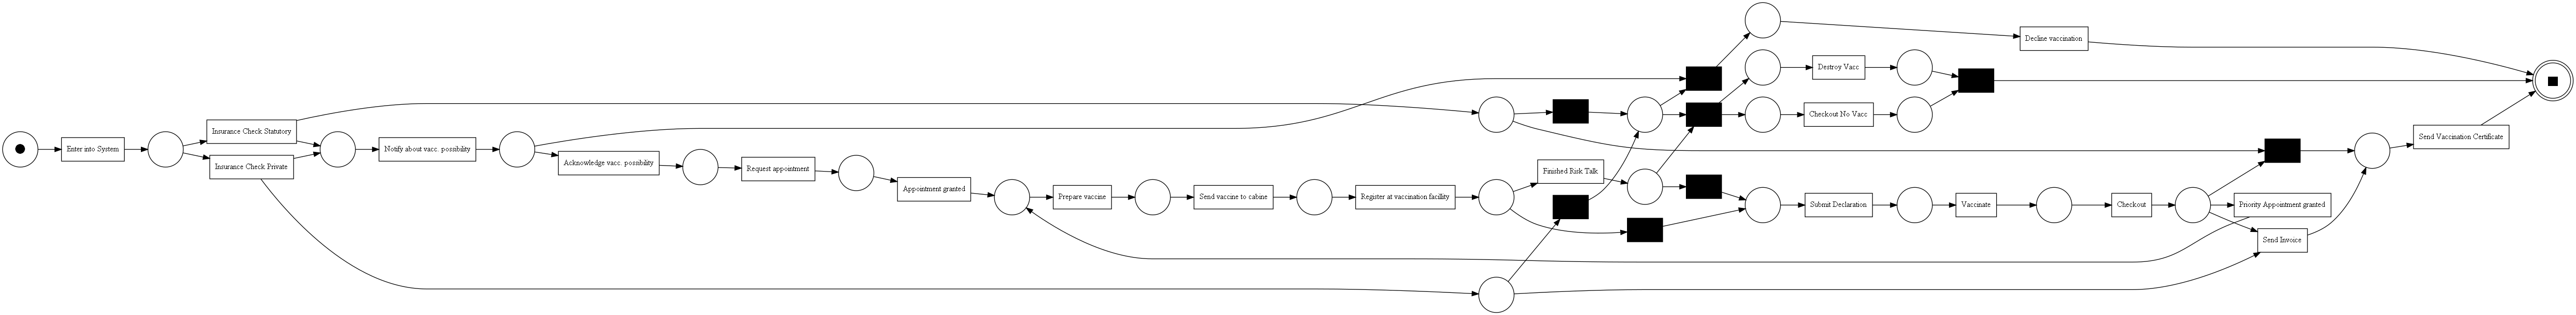

In [29]:
gviz = pn_visualizer.apply(pn_full_hand, im_full_hand, fm_full_hand)
pn_visualizer.view(gviz)

# Performance